In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# 1. Paths
train_path = 'train'
val_path = 'validation'
test_path = 'test'

In [3]:
# 2. Load Data with Rescaling
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [4]:
train_data = train_gen.flow_from_directory(train_path, target_size=(128, 128), batch_size=32, class_mode='binary')
val_data = val_gen.flow_from_directory(val_path, target_size=(128, 128), batch_size=32, class_mode='binary')
test_data = test_gen.flow_from_directory(test_path, target_size=(128, 128), batch_size=32, class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


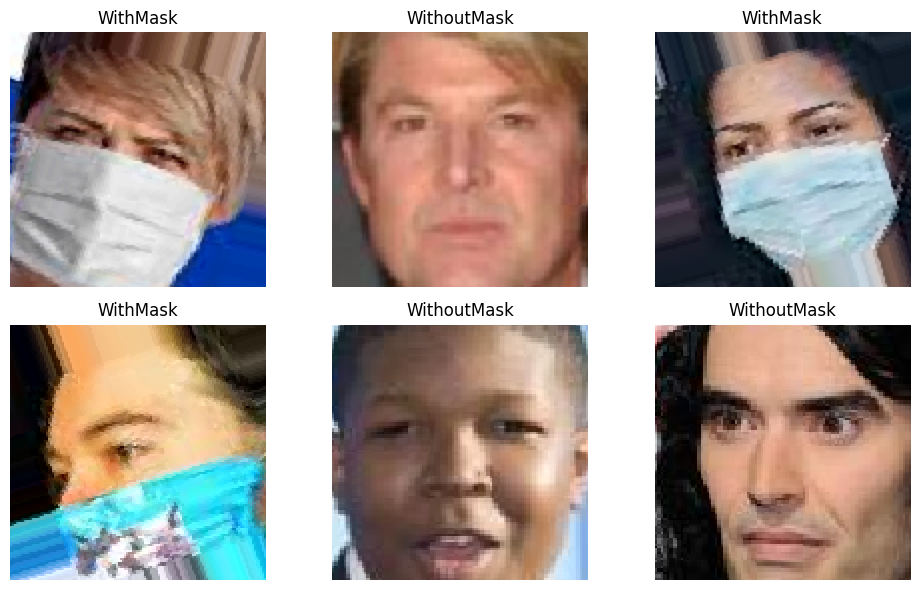

In [5]:
# 3. Corrected visualization
images, labels = next(train_data)
class_names = list(train_data.class_indices.keys())

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    label = int(labels[i])
    plt.title(class_names[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# 4. Load MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [7]:
# 5. Add Classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [8]:
# 6. Compile
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# 7. Train (Top Layers)
history = model.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
313/313 [==============================] - 79s 245ms/step - loss: 0.2271 - accuracy: 0.9053 - val_loss: 0.0401 - val_accuracy: 0.9862
Epoch 2/5
313/313 [==============================] - 73s 233ms/step - loss: 0.0921 - accuracy: 0.9668 - val_loss: 0.0271 - val_accuracy: 0.9912
Epoch 3/5
313/313 [==============================] - 72s 231ms/step - loss: 0.0651 - accuracy: 0.9771 - val_loss: 0.0221 - val_accuracy: 0.9925
Epoch 4/5
313/313 [==============================] - 75s 239ms/step - loss: 0.0552 - accuracy: 0.9824 - val_loss: 0.0175 - val_accuracy: 0.9937
Epoch 5/5
313/313 [==============================] - 73s 233ms/step - loss: 0.0469 - accuracy: 0.9835 - val_loss: 0.0169 - val_accuracy: 0.9950


In [10]:
# 8. Fine-tune top MobileNet layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
313/313 [==============================] - 99s 306ms/step - loss: 0.3266 - accuracy: 0.8998 - val_loss: 0.0208 - val_accuracy: 0.9937
Epoch 2/5
313/313 [==============================] - 91s 290ms/step - loss: 0.0687 - accuracy: 0.9781 - val_loss: 0.0139 - val_accuracy: 0.9950
Epoch 3/5
313/313 [==============================] - 90s 289ms/step - loss: 0.0425 - accuracy: 0.9863 - val_loss: 0.0113 - val_accuracy: 0.9962
Epoch 4/5
313/313 [==============================] - 90s 288ms/step - loss: 0.0346 - accuracy: 0.9875 - val_loss: 0.0072 - val_accuracy: 0.9962
Epoch 5/5
313/313 [==============================] - 94s 299ms/step - loss: 0.0296 - accuracy: 0.9898 - val_loss: 0.0071 - val_accuracy: 0.9962


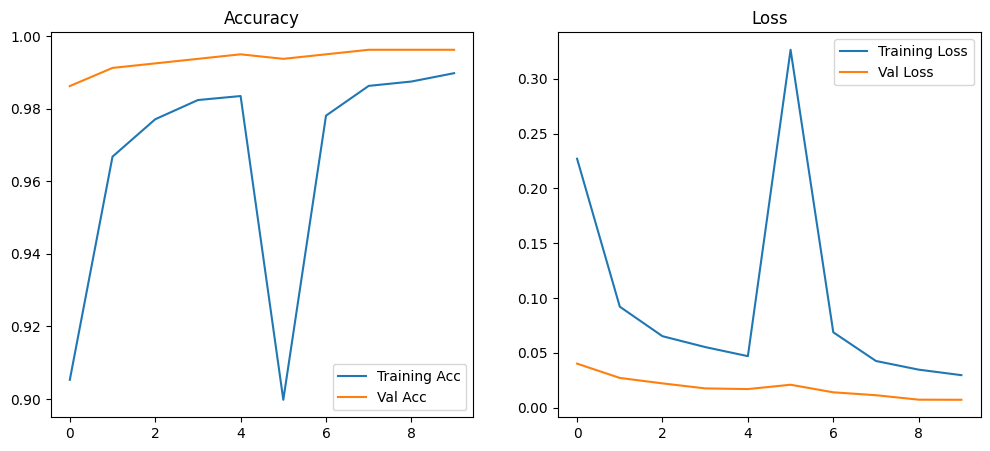

In [11]:
# 9. Plot Accuracy and Loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc + history_finetune.history['accuracy'], label='Training Acc')
    plt.plot(val_acc + history_finetune.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(loss + history_finetune.history['loss'], label='Training Loss')
    plt.plot(val_loss + history_finetune.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_history(history)

In [12]:
# 10. Evaluate on Test
loss, acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {acc:.4f}")

31/31 [==============================] - 7s 224ms/step - loss: 0.0137 - accuracy: 0.9940
✅ Test Accuracy: 0.9940


31/31 [==============================] - 7s 215ms/step
              precision    recall  f1-score   support

    WithMask       0.46      0.47      0.46       483
 WithoutMask       0.49      0.49      0.49       509

    accuracy                           0.48       992
   macro avg       0.48      0.48      0.48       992
weighted avg       0.48      0.48      0.48       992



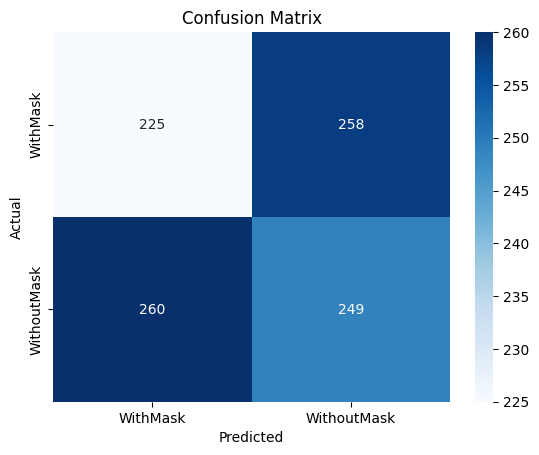

In [13]:
# 11. Confusion Matrix
y_pred = model.predict(test_data)
y_pred_labels = (y_pred > 0.5).astype(int)
y_true = test_data.classes

print(classification_report(y_true, y_pred_labels, target_names=class_names))
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# 12. Save Model
model.save("face_mask_model.h5")
print("Model saved as face_mask_model.h5")

C:\Users\gedel\anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
